# Analyzing Amazon Review Data in Electronics

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
import math
import gzip
import json
from datetime import datetime
import plotly.express as px
import cufflinks as cf
import plotly
import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
cf.go_offline() # required to use plotly offline (no account required).
py.init_notebook_mode() # graphs charts inline (IPython).
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.utils import shuffle, resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import string
import pickle
from itertools import chain
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import os

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/Capstone_2')

In [ ]:
os.getcwd()

'/content/drive/MyDrive/Capstone_2'

In [ ]:
# Functions for reading in the dataset obtained from https://nijianmo.github.io/amazon/index.html
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [ ]:
df_init = getDF('reviews_Electronics_5.json.gz')

In [ ]:
# Pickling df to save time
pickle_out=open('df_init', 'wb')
pickle.dump(df_init, pickle_out)
pickle_out.close()

In [ ]:
# Reading in binary data that was pickled above
pickle_in_data = open('df_init','rb')
df_init = pickle.load(pickle_in_data)

In [ ]:
# Creating Copy of Dataframe to Save in Memory
df = df_init.copy(deep=False)

**Feature Descriptions**
- reviewerID – ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin – ID of the product, e.g. 0000013714
- reviewerName – name of the reviewer
- helpful – helpfulness rating of the review, e.g. 2/3
- reviewText – text of the review
- overall – rating of the product
- summary – summary of the review
- unixReviewTime – time of the review (unix time)
- reviewTime – time of the review (raw)

## Data Cleaning

In [ ]:
# Exploring the size of the dataframe
df.shape
# 1,689,188 reviews with 9 features

(1689188, 9)

In [ ]:
# Sampling five rows of the dataframe to visually see
df.sample(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
1582650,AECOYDVNOVDD3,B00C5W3CCO,"Judgedread ""rsw""","[0, 0]",Bought this product a few weeks back and was k...,2.0,Good until you drop it,1384214400,"11 12, 2013"
1138256,A3FMJFLC3S3LIH,B005HEDAAQ,Sojae,"[0, 0]",We live in a house built in 1960 so nearly non...,4.0,IF YOU ARE HAVING TROUBLES WITH SET UP READ TH...,1402790400,"06 15, 2014"
1599568,A3D5QMH88JSI84,B00CSMYBFS,"Michael Rothberg ""Michael""","[0, 0]",I actually like this case very much despite so...,4.0,Nice thin case,1387238400,"12 17, 2013"
674063,A2CJFSYBYFLD8R,B002W3IXZW,John Longmire,"[0, 0]","good trigger, cheap and sturdy item... much mo...",5.0,sturdy,1365724800,"04 12, 2013"
1548460,A88X0ECDRL174,B00B70KYOO,Hugo Dominguez,"[0, 0]",Love it. This case is perfect to protect my Z1...,5.0,"Great product, good price. No complains",1384300800,"11 13, 2013"


In [ ]:
# Combining reviewText and summay features to create a single feature containing all of the natural language for a review
df['combined_text'] = df['reviewText'] + ' ' +df['summary']
# Dropping summary and reviewText since they are no longer needed
df.drop(['reviewText', 'summary'], axis=1, inplace=True)

In [ ]:
# # Cleaning combined_Text feature
# def preprocess(ReviewText):
#     ReviewText = ReviewText.str.replace("(<br/>)", "")
#     ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
#     ReviewText = ReviewText.str.replace('(&amp)', '')
#     ReviewText = ReviewText.str.replace('(&gt)', '')
#     ReviewText = ReviewText.str.replace('(&lt)', '')
#     ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
#     return ReviewText

# df['combined_text'] = preprocess(df['combined_text'])
# # SOURCE: https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

In [ ]:
# # Creating new feature for word count in reviewText
# df['word_count'] = df['combined_text'].apply(lambda x: len(str(x).split()))
# # Creating new feature for review length
# df['review_len'] = df['combined_text'].astype(str).apply(len)
# # Creating new feature for review polarity
# df['polarity'] = df['combined_text'].map(lambda text: TextBlob(text).sentiment.polarity)

In [ ]:
# print('5 random reviews with the highest positive sentiment polarity: \n')
# cl = df.loc[df.polarity == 1, ['combined_text']].sample(5).values
# for c in cl:
#     print(c[0])

In [ ]:
# One of the first things that I noticed is that the 'helpful' feature will need to be massaged because it is currently in the form of a tuple.
def helpful_decomposition(df): 
    """This function extracts information out of the tuple 'helpful' 
    feature so that we can start to create some other features"""
    
    df['helpful_votes'] = df.helpful.apply(lambda x: x[0])
    df['overall_votes'] = df.helpful.apply(lambda x: x[1])
    df['pct_helpful'] = round((df['helpful_votes'] / df['overall_votes']) * 100)
    df['review_helpful'] = np.where((df.pct_helpful > 60) & (df.overall_votes > 5), 1, 0)
    # Dropping helpful feautre since it is no longer needed
    df.drop('helpful', axis=1, inplace=True)

In [ ]:
# Calling function to decompose the 'helpful' feature
helpful_decomposition(df)
# The dataframe now has some new features that make the 'helpful' columns more meaningful

In [ ]:
df.shape
# df now has more feature columns

(1689188, 11)

In [ ]:
df.isnull().sum()
# It appears that we have some missing data in the 'reviewName' feature and the 'percent_helpful' features

reviewerID             0
asin                   0
reviewerName       24730
overall                0
unixReviewTime         0
reviewTime             0
combined_text          0
helpful_votes          0
overall_votes          0
pct_helpful       963227
review_helpful         0
dtype: int64

In [ ]:
missing_helpful = df[df['pct_helpful'].isnull()]
missing_helpful.sample(2)
# It appears that the pct_helpful columns is NaN because there are no votes for that product review.

,reviewerID,asin,reviewerName,overall,unixReviewTime,reviewTime,combined_text,helpful_votes,overall_votes,pct_helpful,review_helpful
327640,A1QX8L7XVP9SGT,B000VB5MZG,Dave,4.0,1384819200,"11 19, 2013",This is a great way to back-up your computer s...,0,0,NaN,0
755188,A3OX5VX7B7QNEO,B003DVTWQ6,Windy,5.0,1401148800,"05 27, 2014",We keep clones of hard drives for machines tha...,0,0,NaN,0


In [ ]:
# Filling those NaN values with 0 for now
df['pct_helpful'] = df['pct_helpful'].fillna(0)

In [ ]:
df.sample(2)

,reviewerID,asin,reviewerName,overall,unixReviewTime,reviewTime,combined_text,helpful_votes,overall_votes,pct_helpful,review_helpful
1253402,A1DEHS1DB47074,B006YG96KO,bluebob951,5.0,1401235200,"05 28, 2014",I have tried numerous RAM modules from differe...,0,0,0.0,0
306278,A1JJH3POKY6OAO,B000S5Q9CA,"LE ""LE""",1.0,1336003200,"05 3, 2012",This is a cheap knock off. Don't buy it. I w...,0,1,0.0,0


In [ ]:
# Converting Unix to to datetime
df['review_Time'] = pd.to_datetime(df['unixReviewTime'], unit='s')
df.drop(['unixReviewTime', 'reviewTime'], axis=1, inplace=True)

## EDA

In [ ]:
# Summary statistics on numeric features
df.describe()

,overall,helpful_votes,overall_votes,pct_helpful,review_helpful
count,1.689188e+06,1.689188e+06,1.689188e+06,1.689188e+06,1.689188e+06
mean,4.222779e+00,3.160563e+00,3.780423e+00,3.219079e+01,8.455838e-02
std,1.185632e+00,3.896195e+01,4.067347e+01,4.368224e+01,2.782235e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e+00,1.000000e+00,2.000000e+00,8.800000e+01,0.000000e+00
max,5.000000e+00,3.073500e+04,3.145300e+04,1.000000e+02,1.000000e+00


In [ ]:
# Checking the number of ratings for each star category
df.overall.value_counts()  

5.0    1009026
4.0     347041
3.0     142257
1.0     108725
2.0      82139
Name: overall, dtype: int64

In [ ]:
# Creating a new binary target column for Fine-Grained Sentiment Analysis
# Classifying reviews >=3 as negative and review >3 as positive
df['binary_target'] = [0 if i<=3 else 1 for i in df.overall]

In [ ]:
df.sample(2)

,reviewerID,asin,reviewerName,overall,combined_text,helpful_votes,overall_votes,pct_helpful,review_helpful,review_Time,binary_target
1002148,A2FYUYASY9C3YV,B004Q0PT3I,Michhub,4.0,I had to replace the original HD in a HP Probo...,0,0,0.0,0,2013-05-09,1
341911,A2IWIAJ4EXXFSG,B000WOWUKM,Tony Wheeler,5.0,I bought this radio for my wife so she could r...,32,33,97.0,1,2008-02-24,1


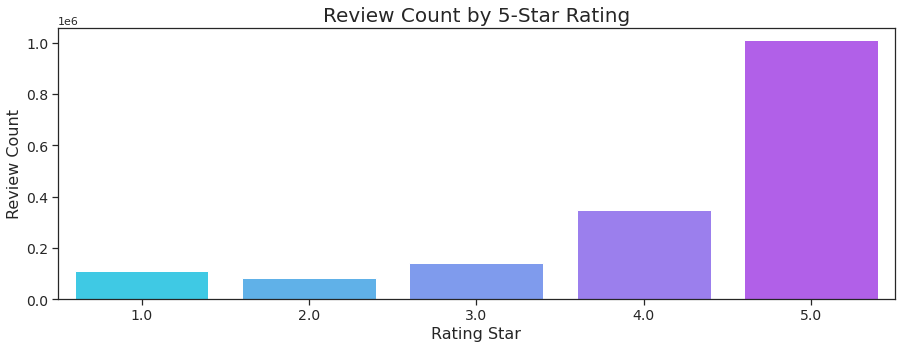

In [ ]:
# Plotting review counts by the 5-star rating
rating = pd.DataFrame(df['overall'].value_counts()).reset_index().sort_values(by='index',ascending=True)
_ = sns.set_style("ticks")
_ = plt.figure(figsize=(15,5))
_ = sns.color_palette("cool")
_ = sns.countplot(x='overall', data=df, palette=_)
_ = plt.xticks(fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.xlabel('Rating Star',fontsize=16)
_ = plt.ylabel('Review Count',fontsize=16)
_ = plt.title('Review Count by 5-Star Rating',fontsize=20)

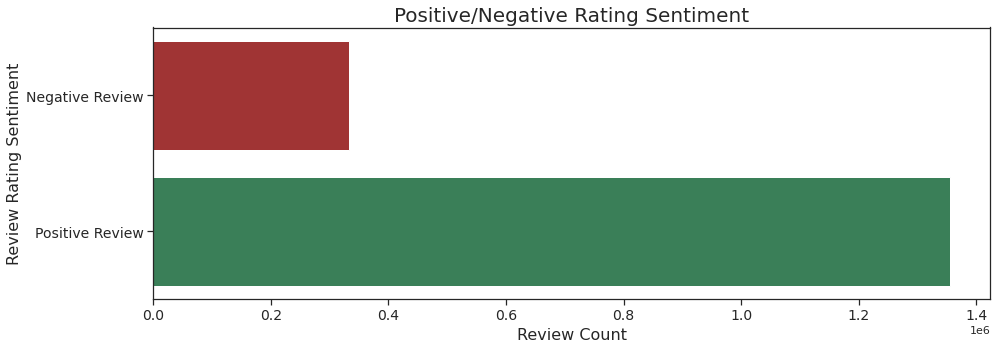

In [ ]:
# Visualiztion the number of postive and negative reviews
_ = plt.figure(figsize=(15,5))
_ = sns.color_palette(['firebrick','seagreen'])
_ = sns.countplot(y='binary_target', data=df, palette=_, orient='h')
_ = sns.set_style("ticks")
_ = plt.yticks([0,1],['Negative Review','Positive Review'], fontsize=14)
_ = plt.xticks(fontsize=14)
_ = plt.ylabel('Review Rating Sentiment',fontsize=16)
_ = plt.xlabel('Review Count',fontsize=16)
_ = plt.title('Positive/Negative Rating Sentiment',fontsize=20)
# It is pretty clear that the majority of the reviews are positive

In [ ]:
time_series_pos = df[df.binary_target==1][['review_Time','overall']]
time_series_pos['count'] = [ 1 for i in time_series_pos.review_Time] 

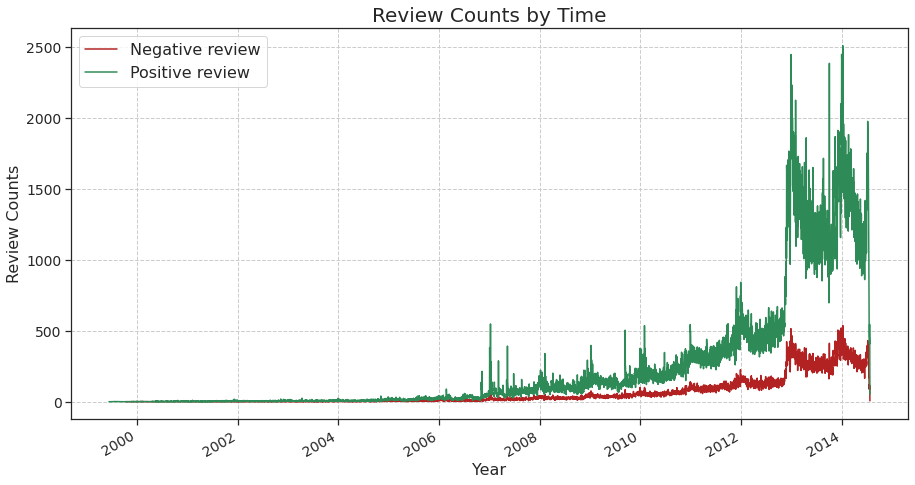

In [ ]:
# Plotting the number of reviews across time from 1999 to 2015
_ = plt.figure(figsize=(15,8))
_ = df[df.binary_target==0]['review_Time'].value_counts().plot(label='Negative review',color='firebrick')
_ = df[df.binary_target==1]['review_Time'].value_counts().plot(label='Positive review',color='seagreen')
_ = plt.title('Review Counts by Time',fontsize=20)
_ = plt.xticks(fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.ylabel('Review Counts',fontsize=16)
_ = plt.xlabel('Year',fontsize=16)
_ = plt.legend(fontsize=16)
_ = plt.grid(ls='--')
_ = sns.set()
_ = plt.show()
# It's clear that majority of the reviews have been over the last 3 years

In [ ]:
# Selecting top 10 products by review volume
top10_rating = df[df['asin'].isin(df.asin.value_counts().nlargest(10).index.to_list())]
top10_rating = pd.DataFrame(top10_rating.groupby('asin')['overall'].mean())
# Review volume of top 10 products
top10_vol =pd.DataFrame(df['asin'].value_counts()).sort_values(by='asin',ascending=False).iloc[:10]

In [ ]:
# Looking at top 10 products by volume and their repsective star ratings
top10 = top10_vol.join(top10_rating)
top10

,asin,overall
B007WTAJTO,4915,4.587589
B003ES5ZUU,4143,4.800386
B00DR0PDNE,3798,3.997894
B0019EHU8G,3435,4.801164
B002WE6D44,2813,4.659794
B003ELYQGG,2652,4.355958
B0002L5R78,2599,4.599846
B009SYZ8OC,2542,4.444925
B00BGGDVOO,2104,4.421578
B002V88HFE,2082,4.736311


In [ ]:
# Top 10 product ID numbers
top10_asin = df.asin.value_counts().nlargest(10).index.to_list()
top10_asin

['B007WTAJTO',
 'B003ES5ZUU',
 'B00DR0PDNE',
 'B0019EHU8G',
 'B002WE6D44',
 'B003ELYQGG',
 'B0002L5R78',
 'B009SYZ8OC',
 'B00BGGDVOO',
 'B002V88HFE']

In [ ]:
# Looked up the names of these products using the following website
# https://amazon-asin.com/asincheck/?product_id=B002V88HFE
top10_productNames = ['SanDisk Ultra 64GB MicroSDXC Class 10 UHS Memory Card',
                      'AmazonBasics High-Speed HDMI Cable with Ethernet',
                      ''
                      'Mediabridge HDMI Cable (6 Feet)',
                      'Transcend 8GB Class 10 SDHC Card',
                      'Panasonic ErgoFit In-Ear Earbud Headphones',
                      '',
                      '',
                      'Roku 3 Streaming Media Player (2014 model)',
                      'eneloop SEC-CSPACER4PK C Size Spacers for use with AA battery cells' 
                     ]

In [ ]:
# Zipping the above lists together
top10_zipped = list(zip(top10_asin, top10_productNames))

## Extracting N-Gram Features

In [ ]:
def get_top_n_words(corpus, n_grams, n=None):
    vec = CountVectorizer(ngram_range=(n_grams,n_grams)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
#source:https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

### -- Bigrams

In [ ]:
# %%time
# # Selecting top 20 most common bigrams for both postivie and negative reviews
# common_words_pos = get_top_n_words(df[df['binary_target']==1]['combined_text'], n_grams=2, n=20)
# common_words_neg = get_top_n_words(df[df['binary_target']==0]['combined_text'], n_grams=2, n=20)

In [ ]:
# # Writing the above output to csv files because the compute time is very long
# pd.DataFrame(common_words_pos, columns = ['combined_text' , 'count']).to_csv('common_bigrams_pos_BEFORE.csv', index=False)
# pd.DataFrame(common_words_neg, columns = ['combined_text' , 'count']).to_csv('common_bigrams_neg_BEFORE.csv', index=False)

In [ ]:
# Distribution of postive bigrams BEFORE removing stop words
enable_plotly_in_cell()
df1 = pd.read_csv('common_bigrams_pos_BEFORE.csv') # Reading in csv that was created from above cells
df1.groupby('combined_text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', color='seagreen', yTitle='Count', linecolor='black', title='Top 20 bigrams in postive reviews (before removing stop words)')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Distribution of negative bigrams BEFORE removing stop words
enable_plotly_in_cell()
df2 = pd.read_csv('common_bigrams_neg_BEFORE.csv')
df2.groupby('combined_text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', color='firebrick', yTitle='Count', linecolor='black',
    title='Top 20 bigrams in negative review (before removing stop words)')

Output hidden; open in https://colab.research.google.com to view.

### -- Trigrams

In [ ]:
# %%time
# # Selecting top 20 most common trigrams for both postivie and negative before removing stopwords
# common_trigrams_pos = get_top_n_words(df[df['binary_target']==1]['combined_text'], n_grams=3, n=20)
# common_trigrams_neg = get_top_n_words(df[df['binary_target']==0]['combined_text'], n_grams=3, n=20)

In [ ]:
# # Writing the above output to csv files because the compute time is very long
# pd.DataFrame(common_trigrams_pos, columns = ['combined_text' , 'count']).to_csv('common_trigrams_pos_BEFORE.csv', index=False)
# pd.DataFrame(common_trigrams_neg, columns = ['combined_text' , 'count']).to_csv('common_trigrams_neg_BEFORE.csv', index=False)

In [ ]:
# Distribution of postive trigrams BEFORE removing stop words
enable_plotly_in_cell()
df3 = pd.read_csv('common_trigrams_pos_BEFORE.csv')
df3.groupby('combined_text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', color='seagreen', yTitle='Count', linecolor='black', title='Top 20 trigrams in postive reviews (before removing stop words)')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Distribution of negative trigrams BEFORE removing stop words
enable_plotly_in_cell()
df4 = pd.read_csv('common_trigrams_neg_BEFORE.csv')
df4.groupby('combined_text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', color='firebrick', yTitle='Count', linecolor='black', title='Top 20 trigrams in negative reviews (before removing stop words)')

Output hidden; open in https://colab.research.google.com to view.

## Removing Stop Words and Processing Data

In [ ]:
import nltk
nltk.download('stopwords')

# Create Stop words list
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘',"'", '©',
'said',"'s", "also",'one',"n't",'com', 'satirewire', '-', '–', 
'—', '_','satirewire.com',"/"]
sw_set = set(sw_list)

# tokenization
def process_review(review):
    tokens = nltk.word_tokenize(review) # tokenization
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set]# stop workds removal
    return stopwords_removed

# Stemming
from nltk.stem import PorterStemmer
ps = PorterStemmer()
# create a function stemming() and loop through each word in a review
def stemming(review):
    stemmed_review=[]
    for w in review:
        stemmed_review.append(ps.stem(w))
    return stemmed_review

# import libraries
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# create a function  and loop through each word in  a review
def lemmatization(review):
    lemma_list=[]
    for word in review:
        lemma_word=lemmatizer.lemmatize(word,pos='v') 
        lemma_list.append(lemma_word)
    return lemma_list

# Conbime all functions above and obtian cleaned text data 
def data_preprocessing(review):
    #tokenization, stop words removal, punctuation marks removel
    processed_review=list(map(process_review,review))
    # stemming
    stemming_reviews=list(map(stemming,processed_review))
    # lemmatization
    lemma_reviews=list(map(lemmatization,stemming_reviews))
    return lemma_reviews

# Source: https://medium.com/swlh/natural-language-processing-nlp-analysis-with-amazon-review-data-part-i-data-engineering-6573b782e4dc63222222222222222222222222222222222.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# DO NOT RUN, OUTPUT IS PICKLED
# %%time
# cleaned_text_data=data_preprocessing(df['combined_text'])

In [ ]:
# # Pickling cleaned_text_data to reduce computational time
# pickle_out=open('cleaned_text_data', 'wb')
# pickle.dump(cleaned_text_data, pickle_out)
# pickle_out.close()

### Positive vs. Negative Revews After Text Processing

In [ ]:
# Reading in binary data that was pickled above
pickle_in_data = open("cleaned_text_data","rb")
cleaned_text_data = pickle.load(pickle_in_data)

In [ ]:
# Addding features for clean reviews (removed sw, lemmatization, stemming, tokenized)
df['review_clean'] = cleaned_text_data 
# Creating review length feature
df['review_length'] = [len(x) for x in df['review_clean']]

# Creating filtered df's for positive and negative reviews
pos_rev = df[df['binary_target']==1]['review_clean']
neg_rev = df[df['binary_target']==0]['review_clean']

In [ ]:
#pd.DataFrame(pd.Series(chain(*goodreviews)).value_counts())
pos_rev_words = pd.DataFrame(pd.Series(chain(*pos_rev)).value_counts()).sort_values(by=0,ascending=False).reset_index().rename(columns={'index':'word',0:'count'})
neg_rev_words = pd.DataFrame(pd.Series(chain(*neg_rev)).value_counts()).sort_values(by=0,ascending=False).reset_index().rename(columns={'index':'word',0:'count'})

### Top Words Used

In [ ]:
# Top 20 words use in positive reviews
enable_plotly_in_cell()
fig = px.bar(pos_rev_words, x=pos_rev_words['word'].iloc[:20], y=pos_rev_words['count'].iloc[:20], template='ggplot2',
             title='Top 20 words used in postive reviews', opacity=0.6)
fig.update_traces(marker_color='seagreen')
fig.update_layout(xaxis_title='Words', yaxis_title='Count')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Top 20 words use in negative reviews
enable_plotly_in_cell()
fig = px.bar(neg_rev_words, x=neg_rev_words['word'].iloc[:20], y=neg_rev_words['count'].iloc[:20], template='ggplot2',
             title='Top 20 words used in negative reviews', opacity=0.6)
fig.update_traces(marker_color='firebrick')
fig.update_layout(xaxis_title='Words', yaxis_title='Count')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# The top word for negative reviews is "work"
# Singular words don't provide us with much context, so let's examine Bigrams and Trigrams

### -- Bigrams After Text Processing

In [ ]:
df['review_clean_string'] = df['review_clean'].apply(lambda x: ' '.join(map(str, x)))

In [ ]:
# %%time
# # Selecting top 20 most common bigrams for both postivie and negative reviews
# processed_bigrams_pos = get_top_n_words(df[df['binary_target']==1]['review_clean_string'], n_grams=2, n=20)
# processed_bigrams_neg = get_top_n_words(df[df['binary_target']==0]['review_clean_string'], n_grams=2, n=20)

In [ ]:
# # Writing the above output to csv files because the compute time is very long
# pd.DataFrame(processed_bigrams_pos, columns = ['review_clean_string' , 'count']).to_csv('processed_bigrams_pos.csv', index=False)
# pd.DataFrame(processed_bigrams_neg, columns = ['review_clean_string' , 'count']).to_csv('processed_bigrams_neg.csv', index=False)

In [ ]:
# Distribution of postive bigrams BEFORE removing stop words
enable_plotly_in_cell()
df5 = pd.read_csv('processed_bigrams_pos.csv')
df5.groupby('review_clean_string').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', color='seagreen', yTitle='Count', linecolor='black', title='Top 20 bigrams in postive reviews after processing')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Distribution of negative trigrams after text processing
enable_plotly_in_cell()
df6 = pd.read_csv('processed_bigrams_neg.csv')
df6.groupby('review_clean_string').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', color='firebrick', yTitle='Count', linecolor='black', title='Top 20 bigrams in negative reviews after processing')

Output hidden; open in https://colab.research.google.com to view.

### -- Trigrams After Text Processing

In [ ]:
# %%time
# # Selecting top 20 most common bigrams for both postivie and negative reviews
# processed_trigrams_pos = get_top_n_words(df[df['binary_target']==1]['review_clean_string'], n_grams=3, n=20)
# processed_trigrams_neg = get_top_n_words(df[df['binary_target']==0]['review_clean_string'], n_grams=3, n=20)

In [ ]:
# # Writing the above output to csv files because the compute time is very long
# pd.DataFrame(processed_trigrams_pos, columns = ['review_clean_string' , 'count']).to_csv('processed_trigrams_pos.csv', index=False)
# pd.DataFrame(processed_trigrams_neg, columns = ['review_clean_string' , 'count']).to_csv('processed_trigrams_neg.csv', index=False)

In [ ]:
# Distribution of postive bigrams after text processing
enable_plotly_in_cell()
df7 = pd.read_csv('processed_trigrams_pos.csv')
df7.groupby('review_clean_string').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', color='seagreen', yTitle='Count', linecolor='black', title='Top 20 trigrams in postive reviews after processing')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Distribution of negative trigrams after text processing
enable_plotly_in_cell()
df8 = pd.read_csv('processed_trigrams_neg.csv')
df8.groupby('review_clean_string').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', color='firebrick', yTitle='Count', linecolor='black', title='Top 20 trigrams in negative reviews after processing')

Output hidden; open in https://colab.research.google.com to view.

## Review Length

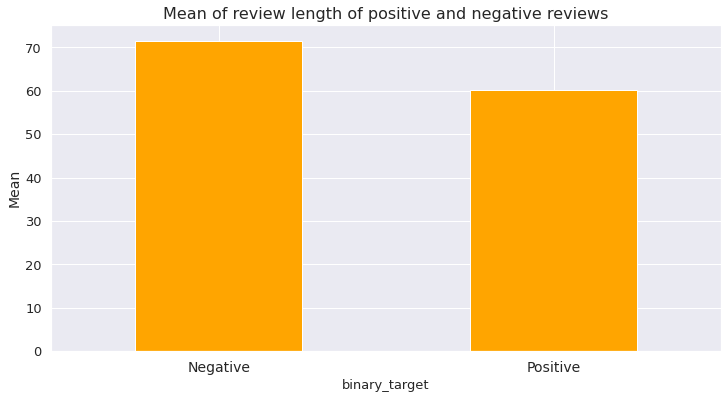

In [ ]:
_ = plt.figure(figsize=(12,6))
_ = df.groupby('binary_target')['review_length'].mean().plot(kind='bar', color='orange', fontsize=13)
_ = plt.xlabel('binary_target', fontsize=13)
_ = plt.ylabel('Mean', fontsize=14)
_ = plt.title('Mean of review length of positive and negative reviews', fontsize=16)
_ = plt.xticks([1,0],['Positive','Negative'], rotation=0, fontsize=14)
_ = plt.show()

In [ ]:
# It seems intuitive that negative reviews would be longer on average. Generally,
# humans tend to be more vocal about something that displeases them.

In [ ]:
# Plotting review length distributions
enable_plotly_in_cell()
x1 = df.loc[df['binary_target'] == 1, 'review_length']
x0 = df.loc[df['binary_target'] == 0, 'review_length']

trace0 = go.Histogram(
    x=x0, name='Positive Review',
    opacity=0.75, marker_color='seagreen'
)
trace1 = go.Histogram(
    x=x1, name = 'Negative Review',
    opacity=0.75, marker_color='firebrick'
)

data = [trace1, trace0]
layout = go.Layout(barmode='overlay', title='Distributions of Review Lengths')
fig = go.Figure(data=data, layout=layout)
fig.update_layout(xaxis=(dict(range=[0,100])))

fig.show()

# These are both heavily right skewed distributions

Output hidden; open in https://colab.research.google.com to view.

## Word Clouds

In [ ]:
tri_pos = pd.read_csv('processed_trigrams_pos.csv')
tri_neg = pd.read_csv('processed_trigrams_neg.csv')
bi_pos = pd.read_csv('processed_bigrams_pos.csv')
bi_neg = pd.read_csv('processed_bigrams_neg.csv')

In [ ]:
# Creating dictionaries of positive/negative n-grams for word clouds
bi_pos_dict = bi_pos.groupby('review_clean_string')['count'].apply(int).to_dict()
bi_neg_dict = bi_neg.groupby('review_clean_string')['count'].apply(int).to_dict()
tri_pos_dict = tri_pos.groupby('review_clean_string')['count'].apply(int).to_dict()
tri_neg_dict = tri_neg.groupby('review_clean_string')['count'].apply(int).to_dict()

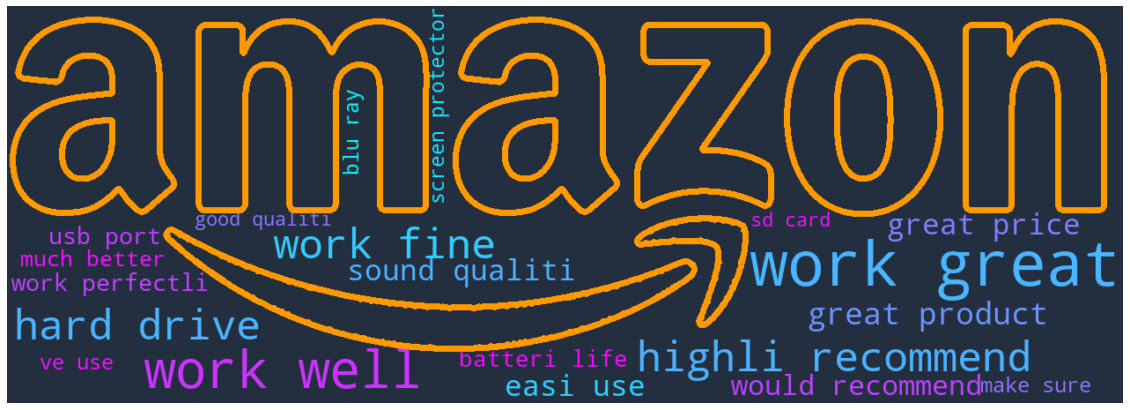

In [ ]:
# Word Clouds for positive bigrams

# open the image and use np.array to transform the file to an array
cand_mask=np.array(Image.open('amazon_logo.png'))

# this line will take all values greater than 3 and make them 255 (white)
# if they are less than 3, they will be whatever value they are in the array
cand_mask=np.where(cand_mask > 3, 255, cand_mask)

#create and generate our wordcloud object
wordcloud = WordCloud(width=1600, height=800,
                      background_color=(35, 47, 62),
                      contour_color=(255,153,0),
                      mask=cand_mask, 
                      colormap='cool',
                      contour_width=10).generate_from_frequencies(bi_pos_dict)

#plot
_ = plt.figure(figsize=(20,10))
_ = plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis('off')
_ = plt.show()
# Source: https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb

## Review Helpfulness Scores

In [ ]:
pos_helpful = df[df['binary_target']==1]['pct_helpful'].mean()
neg_helpful = df[df['binary_target']==0]['pct_helpful'].mean()

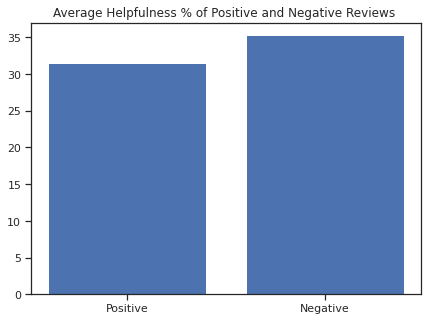

In [ ]:
_ = plt.figure(figsize=(7,5))
_ = sns.set_style("ticks")
_ = plt.bar(['Positive', 'Negative'], [pos_helpful, neg_helpful])
_ = plt.title('Average Helpfulness % of Positive and Negative Reviews ')
_ = plt.show()
# It looks like buyers tend to think critical reviews are more helpful